In [ ]:
# uncomment if you don't have cvxpy installed
# import pip
# pip.main(['install', 'cvxpy'])

In [ ]:
import cvxpy as cp
import numpy as np
from matplotlib import pyplot as plt

# Solving Optimization Problem is Easy.

[Slides for today](https://docs.google.com/presentation/d/1Q037-jUDw1U9jsJQ82okcIm0UED3Cm6If8ppfvyt_Fg/edit?usp=sharing)

## Simple Example

Let us try to solve the equation on the slide. This is to show you the idea that if you can write your problem like this then it's easy. The most important part is not solving it but it's the formulation.

$$
\begin{alignat*}{2}
\underset{x_i \in R}{\operatorname{argmin}} & \quad  & 5x_1 + 3x_2 + 2x_3 & \\
\text{Subject To:} &  & x_1 + x_2 + x_3 &= 1 \\
&  &x_2 + 2 x_3 &\le 5 \\
& & x_1 &\ge 0 \\
& & x_2 &\ge 0 \\
& & x_3 &\ge 0
\end{alignat*}
$$

In [ ]:
# declare your decision variable
x1 = cp.Variable()
x2 = cp.Variable()
x3 = cp.Variable()

# your cost function
cost = 5*x1 + 3*x2 + 2*x3

# your optimization problem
prob = cp.Problem(
    objective = cp.Minimize(cost),
    constraints = [
        x1 + x2 + x3 == 1,
        x2 + 2*x3 <= 5,
        x1 >= 0,
        x2 >= 0,
        x3 >= 0       
    ]
)

# solve and print
prob.solve()
print(prob.status)
print('x1', x1.value)
print('x2', x2.value)
print('x3', x3.value)
print('objective value', prob.value)

## You try it
Find x and y. Note the argmax. You will need to use `cp.Maximize` or just negate the objective function.

$$
\begin{alignat*}{2}
\underset{x,y \in R}{\operatorname{argmax}} & \quad  & 2x + 3y & \\
\text{Subject To:} &  & x+y &\le 1 \\
&  &x & \ge 0 \\
& & y & \ge 0 \\
& & y & \le 0.7
\end{alignat*}
$$

# Dietary Problem



Each day we need at least 2000 KCal and at most 2800 KCal

- at least 56 gram of protein per day
- at 57-80 gram of fat per day

|              | Kcal/g | protein % | fat % | Baht/g |
|--------------|--------|-----------|-------|--------|
| Chicken Rice | 2      | 20        | 20    | 0.2    |
| Cake         | 10     | 10        | 30    | 1.0    |
| Noodles      | 1.8    | 20        | 10    | 0.2    |



In [ ]:
# save you from typing
items_names = ['cake', 'chicken_rice', 'noodles']
item_prices = [0.2, 1.0, 0.2]
item_kcals = [2, 10, 1.8]
max_kcal = 2800
min_kcal = 2000
item_proteins = [0.2, 0.1, 0.2]
min_protein = 56
item_fats = [0.2, 0.3, 0.1]
min_fat = 57
max_fat = 80

## Saving Money

How should we eat these three item such that we use the least amount of money? This is actually a very important problem in defining poverty line.


**Spoiler** Double click here and remove display:none to see the spoiler.

<div style="display: none">
Decision variable $x_i$ how much in gram we should eat.

$$
\begin{alignat*}{2}
\underset{x,y \in R}{\operatorname{argmin}} & \quad  & \sum_i \text{price}_i \times x_i  & \\
\text{Subject To:} &  & \sum_i kcal_i x_i &\le 2800 \\
&  & \sum_i kcal_i x_i &\ge 2000 \\
&  & \sum_i fat_i x_i &\le 80 \\
&  & \sum_i fat_i x_i &\ge 57 \\
&  & \sum_i protein_i x_i & \ge 56 \\
&  &x_i & \ge 0 \\
\end{alignat*}
$$
</div>

In [ ]:
# declare your decision variable
cr = cp.Variable(name='cr')
ca = cp.Variable(name='ca')
no = cp.Variable(name='no')

intake = np.array([cr, ca, no])  # or you can do cp.Variable(3)
total_price = intake @ item_prices  # @ means dot product
kcal = intake @ item_kcals
protein = intake @ item_proteins
fat = intake @ item_fats


# your optimization problem
prob = cp.Problem(
    objective=cp.Minimize(total_price),
    constraints=[
        kcal <= max_kcal,
        kcal >= min_kcal,
        protein >= min_protein,
        fat <= max_fat,
        fat >= min_fat,
    ]
)

# solve and print
prob.solve()
print(prob.status)
for v in prob.variables():
    print(v.name(), v.value)
print(prob.value)

## Money is not the problem. Protein is

What if we want to eat as much protein as much as possible while not getting fat? How much money do we need?

## Low Fat Diet?

Eat the least amount of fat?

# Linearization: These are all actually linear.

The point of this sections is to show you that some seemingly non-linear constraints are actually linear by using some clever tricks.

## Ratio -- Simplified LINOPT

Consider the problem of operating a gas well. Each well has gas potential and its characteristic such as CGR(condensate to gas ratio) and Hg Concentration in oil.

We need to figure out how to operate these well such that we

- meet the nomination of 100MMSCF/Day.
- The Hg concentration is less than 2000ppb.

and we want to maximum the oil production.

We can do this simply by defining gas rates(MMSCF/Day), $g_i$, as our decision variable.

$$
\begin{alignat*}{2}
\underset{g_i \in R}{\operatorname{argmax}} & \quad  & \sum cgr_i \times g_i & \\
\text{Subject To:} &  & \sum g_i &= nom \\
&  & g_i & \ge 0 \\
& & g_i & \le potential_i \\
& & \color{red}{\frac{\sum g_i \times cgr_i \times hg_i}{\sum g_i \times cgr_i}} & \le 2000
\end{alignat*}
$$

The last one constraint however isn't linear. We need to linearize it somehow....

**Spoiler** double click this cell and remove "display:none" to see the spoiler.

<div style="display:none">
The last constraint isn't linear but with some simple algebra we can turn it in to linear.
$$
\sum g_i \times cgr_i \times hg_i\le 2000 \times \left(\sum g_i \times cgr_i\right)
$$

Thus, the problem becomes
$$
\begin{alignat*}{2}
\underset{g_i \in R}{\operatorname{argmax}} & \quad  & \sum cgr_i \times g_i & \\
\text{Subject To:} &  & \sum g_i &= nom \\
&  & g_i & \ge 0 \\
& & g_i & \le potential_i \\
& & \sum g_i \times cgr_i \times hg_i & \le 2000 \times \left(\sum g_i \times cgr_i\right)
\end{alignat*}
$$
</div>

In [ ]:
cgrs = np.array([2., 3., 4., 5.])  # BBL/MMSCF
hgs = np.array([500., 1000, 1500, 2500])  # ppb
potentials = np.array([100., 75, 80, 20])
nom = 100.
n_well = len(cgrs)

## Bounded Absolute Constraint.

What if someone now requires that the last two well different is gas rate should not be more than 50MMSCF/Day? Eg. (the index start from 0)
$$
|gs[2] - gs[3]| \le 50
$$

Basically, we would want something like the following

$$
\begin{alignat*}{2}
\underset{g_i \in R}{\operatorname{argmax}} & \quad  & \sum cgr_i \times g_i & \\
\text{Subject To:} &  & \sum g_i &= nom \\
&  & g_i & \ge 0 \\
& & g_i & \le potential_i \\
& & \sum g_i \times cgr_i \times hg_i & \le 2000 \times \left(\sum g_i \times cgr_i\right)\\
& & \color{red}{|gs_2 - gs_3|} &\le 50
\end{alignat*}
$$

The last constraint is however not linear. Can we linearize it?

**Spoiler**

<div style="display:none">
$|gs_2 - gs_3| \le 50$ means

$$
    -50 \le gs_2 - gs_3 \le 50
$$

Thus we have

$$
\begin{alignat*}{2}
\underset{g_i \in R}{\operatorname{argmax}} & \quad  & \sum cgr_i \times g_i & \\
\text{Subject To:} &  & \sum g_i &= nom \\
&  & g_i & \ge 0 \\
& & g_i & \le potential_i \\
& & \sum g_i \times cgr_i \times hg_i & \le 2000 \times \left(\sum g_i \times cgr_i\right)\\
& & gs_2 - gs_3 &\le 50  \\
& & gs_2 - gs_3 &\ge -50  \\
\end{alignat*}
$$
</div>

In [ ]:
cgrs = np.array([2., 3., 4., 5.])  # BBL/MMSCF
hgs = np.array([500., 1000, 1500, 2500])  # ppb
potentials = np.array([100., 75, 80, 20])
nom = 100.
n_well = len(cgrs)

## Absolute Objective. 
What if now instead of maximize oil, we want to get the total oil as close as possible to 350BBL.

Basically, something along the line of
$$
\begin{alignat*}{2}
\underset{g_i \in R}{\operatorname{argmin}} & \quad  & \color{red}{\left| \sum cgr_i \times g_i - 350 \right|}  & \\
\text{Subject To:} &  & \sum g_i &= nom \\
&  & g_i & \ge 0 \\
& & g_i & \le potential_i \\
& & \sum g_i \times cgr_i \times hg_i & \le 2000 \times \left(\sum g_i \times cgr_i\right)\\
\end{alignat*}
$$

The objective is however non-linear. Can you linearize the it?


*Note*: you may need to change solver https://www.cvxpy.org/tutorial/advanced/index.html#choosing-a-solver

**Spoiler**

<div style="display:none">

We can just move objective to constraint by introducing auxillary variable $t$

$$
\begin{alignat*}{2}
\underset{g_i,t \in R}{\operatorname{argmin}} & \quad  & t  & \\
\text{Subject To:} &  & \sum g_i &= nom \\
&  & g_i & \ge 0 \\
& & g_i & \le potential_i \\
& & \sum g_i \times cgr_i \times hg_i & \le 2000 \times \left(\sum g_i \times cgr_i\right)\\
& & \color{red}{\left| \sum cgr_i \times g_i - 350 \right|} &\le t
\end{alignat*}
$$

Then, we can use the absolute constraint trick we did earlier.

$$
\begin{alignat*}{2}
\underset{g_i,t \in R}{\operatorname{argmin}} & \quad  & t  & \\
\text{Subject To:} &  & \sum g_i &= nom \\
&  & g_i & \ge 0 \\
& & g_i & \le potential_i \\
& & \sum g_i \times cgr_i \times hg_i & \le 2000 \times \left(\sum g_i \times cgr_i\right)\\
& &\sum cgr_i \times g_i - 350 &\le t\\
& &\sum cgr_i \times g_i - 350 &\ge -t\\
\end{alignat*}
$$
</div>


## Sum of Absolute: $\ell_1$ norm

Suppose now, your boss has a number in mind on how much he/she want to operate the gas well.
However the number that they give does not meet the constriant. We want operate the gas well such that
it's the **closest** to what the boss say but still meet the constraint.

In particular, something along the line of the below will do

$$
\begin{alignat*}{2}
\underset{g_i \in R}{\operatorname{argmin}} & \quad  & \color{red}{\sum \left|g_i - boss_i\right|}  & \\
\text{Subject To:} &  & \sum g_i &= nom \\
&  & g_i & \ge 0 \\
& & g_i & \le potential_i \\
& & \sum g_i \times cgr_i \times hg_i & \le 2000 \times \left(\sum g_i \times cgr_i\right)\\
\end{alignat*}
$$

This is called $\ell_1$ norm or [Taxi cab norm](https://en.wikipedia.org/wiki/Taxicab_geometry). This is a pretty decent replacement for non-linear euclidean distance. The subscript 1 is an actual mathematical symbol.
$$
    \lVert \vec{x} \rVert_1 = \sum |x_i|
$$

The objective however, doesn't look like a linear function. Can we linearize it?


**Spoiler**

<div style="display:none">

We just need to do the absolute objective trick multiple times.
Let us define variable $t_i$

$$
\begin{alignat*}{2}
\underset{g_i, t_i \in R}{\operatorname{argmin}} & \quad  & \color{blue}{\sum t_i}  & \\
\text{Subject To:} &  & \sum g_i &= nom \\
&  & g_i & \ge 0 \\
& & g_i & \le potential_i \\
& & \sum g_i \times cgr_i \times hg_i & \le 2000 \times \left(\sum g_i \times cgr_i\right)\\
& & g_i - boss_i &\le t_i\\
& & g_i - boss_i &\ge -t_i
\end{alignat*}
$$
    
</div>

In [ ]:
cgrs = np.array([2., 3., 4., 5.])  # BBL/MMSCF
hgs = np.array([500., 1000, 1500, 2500])  # ppb
potentials = np.array([100., 75, 80, 20])
bosses = np.array([80, 15, 15, 15])
nom = 100.
n_well = len(cgrs)

## Pointwise Maximum $\ell_\infty$ norm

Now your boss changes his mind. All he wants was to operate the well such that the **maximum** deviation from this choice is **minimize**.

$$
\begin{alignat*}{2}
\underset{g_i \in R}{\operatorname{argmin}} & \quad  & \color{red}{\max_i \left|g_i - boss_i\right|}  & \\
\text{Subject To:} &  & \sum g_i &= nom \\
&  & g_i & \ge 0 \\
& & g_i & \le potential_i \\
& & \sum g_i \times cgr_i \times hg_i & \le 2000 \times \left(\sum g_i \times cgr_i\right)\\
\end{alignat*}
$$

The maximum of absolute also has a name it's called infinity norm.
$$
    \lVert \vec{x} \rVert = \max_i |x_i|
$$

Again, we want to linearize this.

**Spoiler**

<div style="display:none">

We can just make them share $t$. Note no index $i$ on $t$

$$
\begin{alignat*}{2}
\underset{g_i, t \in R}{\operatorname{argmin}} & \quad  & t  & \\
\text{Subject To:} &  & \sum g_i &= nom \\
&  & g_i & \ge 0 \\
& & g_i & \le potential_i \\
& & \sum g_i \times cgr_i \times hg_i & \le 2000 \times \left(\sum g_i \times cgr_i\right)\\
& & g_i - boss_i &\le t\\
& & g_i - boss_i  &\ge -t
\end{alignat*}
$$
</div>

## Convex Piecewise Linear
Every purely convex or concave piecewise linear function is actually a pointwise maximum/minimum. This is very useful in approximating a non linear function. The reason it works is illustrated in the picture below.
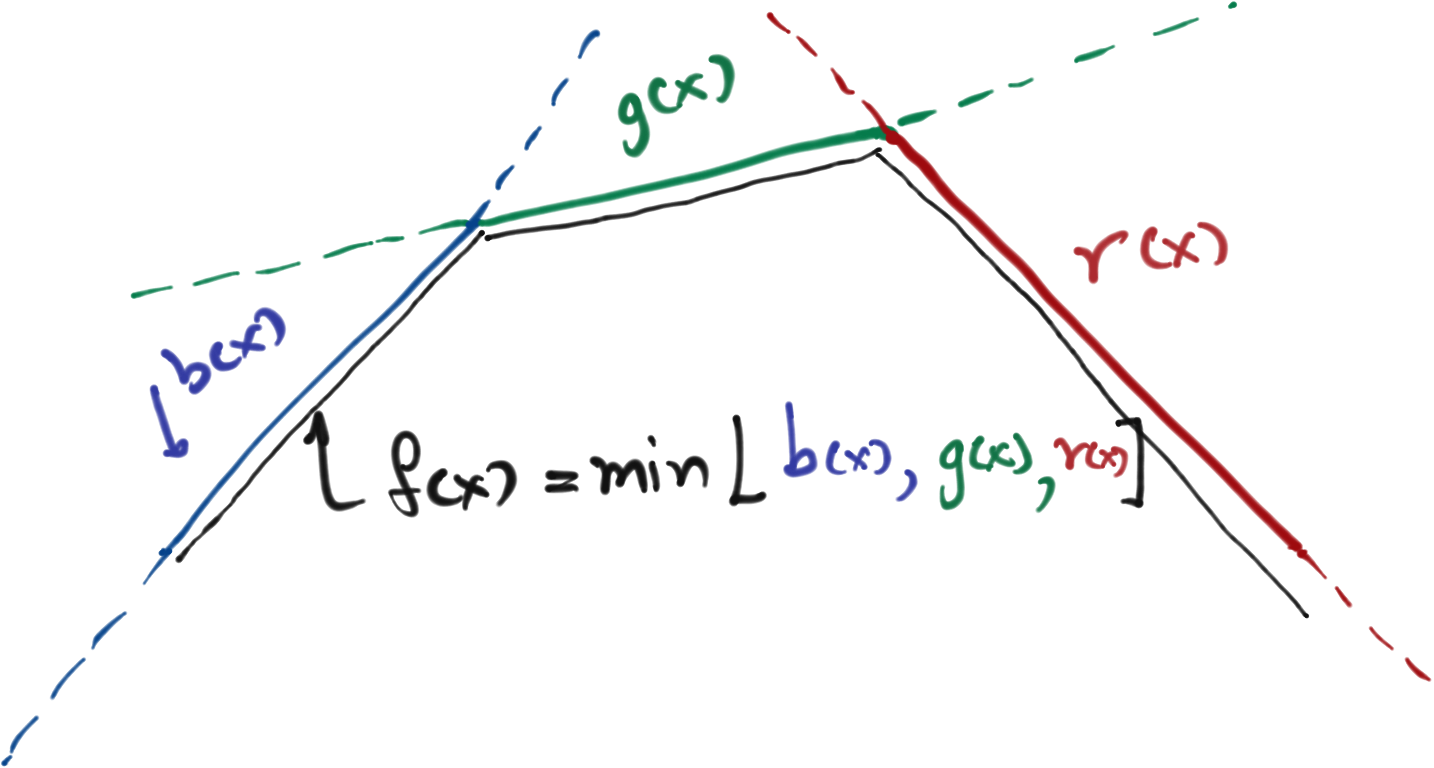

$$
    f(x) = min[\color{blue}{b(x)}, \color{red}{r(x)}, \color{green}{g(x)}]
$$

The same trick is applied for purely convex function as well, just do maximum. Not, all function can do this however, you can try to draw a non convex function and try to do the same maximum trick you will see that you won't get the same function back.

Thus, we can do things like 
$$
\begin{alignat*}{2}
\underset{g_i \in R}{\operatorname{argmax}} & \quad  & \color{red}{f(x)}
\end{alignat*}
$$
is equivalent to

$$
\begin{alignat*}{2}
\underset{g_i \in R}{\operatorname{argmax}} & \quad  & \color{red}{\min [b(x), r(x), g(x)]}
\end{alignat*}
$$

$$
\begin{alignat*}{2}
\underset{g_i \in R}{\operatorname{argmax}} & \quad  & t  & \\
\text{Subject To:} &  & b(x) &\ge t \\
&  & g(x) & \ge t \\
& & r(x) & \ge t
\end{alignat*}
$$

# Interesting Problem

These are some of problems that might be relevant to your line of work.

## Minimax/Maximin: Risk Averse Strategy

When operating a gas field we can varies GCV and amount of condensate produced. Both of which affect the total revenue. If the condesate price is good, we would want to maximize the amount of condensate produced. If condensate price is bad, we would want to maximize GCV. Let's consider a model where

2*GCV + 3*condensate = 20.

The future price, however, is not so certain there are couple scenario and the price varies. Suppose that the economist come up with 3 price scenarios

| Scenario | \$/GCV | \$/BBL |
|----------|-------|-------|
| A        | 20    | 30    |
| B        | 18    | 50    |
| C        | 22    | 15    |

We can choose how much to produce today. The production is **fixed** today. But we have no idea what the price scenario would be in the future. A risk averse strategy would be to produces such that we can guarantee most revenue even if the worst scenario comes up.

Can you find such strategy?

**Spoiler 1** Decision Variable

<div style="display:none">
If we choose our production level at $condy$ and $gcv$, then the profit in the worse case is.
$$
    \min_{i \in Scenario} p_{gcv,i} \times gcv + p_{condy,i} \times condy
$$

Thus our optimization problem is
$$
\begin{alignat*}{2}
\underset{gcv, condy \in R}{\operatorname{argmax}} & \quad  & \color{red}{\min_i p_{gcv,i} \times gcv + p_{condy,i} \times condy}  & \\
\text{Subject To:} &  & 2\times gcv + 3 \times condy &= 20 \\
& & gcv &\ge 0 \\
& & condy &\ge 0
\end{alignat*}
$$

The top part is, again, doesn't look like a linear function. Can you linearize it using the tricks we learned?
</div>

**Spoiler 2** Linearize

<div style="display:none">

$$
\begin{alignat*}{2}
\underset{gcv, condy, t \in R}{\operatorname{argmax}} & \quad  & t  & \\
\text{Subject To:} &  & 2\times gcv + 3 \times condy &= 20 \\
& & gcv &\ge 0 \\
& & condy &\ge 0 \\
& & p_{gcv,i} \times gcv + p_{condy,i} \times condy &\ge t \qquad \forall i
\end{alignat*}
$$

</div>

# Mixed Integer Optimization

Sometime we really want our answer to be integer, for example in our dietary problem. We cannot go to a restaurant and order 0.83 chicken rice. We can order 1,2 or 3 plate of chicken rice.

This is a much much harder problem algorithm-wise than linear programming. It is called (Mixed Integer Linear Programming)[https://en.wikipedia.org/wiki/Integer_programming]. The technique commonly use is by relaxation + branch and bound. We will not cover the algorithm details here. But getting cvxpy to do integer programming is quite simple.

https://www.cvxpy.org/api_reference/cvxpy.expressions.html#leaf

Examples:

``cp.Variable(integer=True)``

``cp.Variable(integer=[5,6,7,8])``

## Integer Dietary



In [ ]:
# declare your decision variable
# save you from typing
items_names = ['cake', 'chicken_rice', 'noodles']
item_prices = [0.2, 1.0, 0.2]
item_kcals = [2, 10, 1.8]
max_kcal = 2800
min_kcal = 2000
item_proteins = [0.2, 0.1, 0.2]
min_protein = 56
item_fats = [0.2, 0.3, 0.1]
min_fat = 57
max_fat = 80

cr_plate = cp.Variable(integer=True) #<<<<<<<<
ca_plate = cp.Variable(integer=True) #<<<<<<<<
no_plate = cp.Variable(integer=True) #<<<<<<<<

cr = cr_plate*200 # 200 gram per plate
ca = ca_plate*100 # 100 gram per cake
no = no_plate*200 # 200 gram per bowl

intake = np.array([cr, ca, no])  # or you can do cp.Variable(3)
total_price = intake @ item_prices  # @ means dot product
kcal = intake @ item_kcals
protein = intake @ item_proteins
fat = intake @ item_fats


# your optimization problem
prob = cp.Problem(
    objective=cp.Minimize(total_price),
    constraints=[
        kcal <= max_kcal,
        kcal >= min_kcal,
        protein >= min_protein,
        fat <= max_fat,
        fat >= min_fat,
        cr_plate >= 0,
        ca_plate >= 0,
        no_plate >= 0
    ]
)

# solve and print
prob.solve()
print(prob.status)
for v in prob.variables():
    print(v.name(), v.value)
print(prob.value)

## Minimum people hired.
Consider manpower allocation to build 4 WHP/infills. Each one has a deadline and the amount of man power needed.

| JOB | Manmonth | Deadline (month) |
|-----|----------|------------------|
|  A  |     3    |         1        |
|  B  |     5    |         2        |
|  C  |     2    |         3        |
|  D  |     1    |         4        |


Once we hire someone we don't want to fire them. Yet, we having too many manpower is a waste of money. So one question is what is the minimum number of people we need to hire to finish the job and how do we allocate them?

**Spoiler 1** Decision Variable

<div style="display:none">

Our decision variable would be a 2d array where the column is month and job. Since we clearly need to finish within 4 months. So, it's a 4 by 4 matrix $A_{job, month}$

|                 | M1 | M2 | M3 | M4 | Total for Job A |
|-----------------|----|----|----|----|-----------------|
| A               | 1  | 2  | 0  | 0  | 3               |
| B               | 2  | 2  | 0  | 0  | 4               |
| C               | 0  | 3  | 1  | 0  | 5               |
| D               | 0  | 0  | 1  | 5  | 6               |
| Total for Month | 3  | 7  | 2  | 5  | Max=7           |
    
</div>

**Spoiler 2** Objective and Constraint

<div style="display:none">
There are lot of useful sum here
$$
    \sum_{m \in months} A_{j,m} = \text{total man month for job $j$}
$$
we need to make sure that this one matches the table, and
$$
    \sum_{j \in jobs} A_{j,m} = \text{total people we need at month $m$}
$$
This is what we want to minimize.

Thus, our optimization problem becomes

$$
\begin{alignat*}{2}
\underset{A_{j,m} \in R}{\operatorname{argmin}} & \quad  & \color{red}{\max_m \sum_j A_{j,m}}  & \\
\text{Subject To:} &  & \sum_{m \in months} A_{j,m} &= \text{total man power needed for job $j$} \\
& & A_{j,m} &\ge 0 \qquad \forall j,m\\
\end{alignat*}
$$

We need to linearize this.
    
</div>

**Spoiler 3** Linearize Objective

<div style="display:none">

$$
\begin{alignat*}{2}
\underset{A_{j,m}, t \in R}{\operatorname{argmin}} & \quad  & t  & \\
\text{Subject To:} &  & \sum_{m \in months} A_{j,m} &= \text{total man power needed for job $j$} \\
& & \sum_j A_{j,m} &\le t  \qquad \forall m \\
& & A_{j,m} &\ge 0 \qquad \forall j,m
\end{alignat*}
$$

But... how about the deadline?    
</div>


**Spoiler 4** Deadline

<div style="display:none">
Yep we did not include the deadline. We can do it by forcing
$$
    A_{j,m} = 0 \qquad \forall m \ge deadline_j
$$
the $\ge$ is because the index starts at 0. The optimization problem becomes

$$
\begin{alignat*}{2}
\underset{A_{j,m} \in I, t \in R}{\operatorname{argmin}} & \quad  & t  & \\
\text{Subject To:} &  & \sum_{m \in months} A_{j,m} &= \text{total man power needed for job $j$} \\
& & \sum_j A_{j,m} &\le t \qquad \forall m \\
& & A_{j,m} &\ge 0 \qquad \forall j,m \\
& & A_{j,m} &= 0 \qquad \forall j,m \;| m \ge deadline_j
\end{alignat*}
$$
</div>

In [ ]:
mps = np.array([3., 5, 2, 1])
deadlines = np.array([1., 2, 3, 4])

## Bipartite Matching Problem: WHP Pairing.

Let us consider the problem of reusing the topside of WHP. We have a donor and receiver. Only some of the pair is compatible due to timing/spec and such. The saving for each pairing depends on the discount rate, spec etc.

This incidence matrix is shown below. Each entry means the saving if we were to pair up the donor with receiver.

| D/R | R1 | R2 | R3 | R4 | R5 |
|-----|----|----|----|----|----|
| D1  | 3  | 2  | 1  | 3  | 0  |
| D2  | 1  | 0  | 0  | 1  | 0  |
| D3  | 1  | 3  | 0  | 3  | 1  |
| D4  | 0  | 2  | 0  | 1  | 2  |
| D5  | 2  | 0  | 1  | 0  | 1  |

What we want to do is to find the pairing that maximize the total saving. Can we write this as linear optimization?


**Spoiler 1** Decision Variable and Objective

<div style="display:none">

We can make our decision variable a matrix of 0 and 1. Where 1 indicate transfer, and 0 means that no transfer/reuse happens

$$
    A_{d, r} = \begin{cases}
    1 & \text{if we donate from $d \rightarrow r$} \\
    0 & \text{if there is donation from $d \rightarrow r$}
    \end{cases}
$$

Then the cost function is just
$$
\text{Total Saving} = \sum_{d,r} A_{d,r} \times S_{d, r}
$$
where $S_{d,r}$ is the saving matrix.

However, we need to make sure that each donor donates at most once and reveiver recive at most once. Can you figure out how to do that?
    
</div>

**Spoiler 2** Constraints

<div style="display:none">

The total donation from $d$ is given by
$$
    \text{Total Donation from d} = \sum_r A_{d, r}
$$
We just need to make sure that this number doesn't exeed 1 for all donors.
$$
    \sum_r A_{d, r} \le 1 \qquad \forall d
$$

Total number of top sides that platform $r$ receives is given by
$$
    \sum_d A_{d, r} \le 1 \qquad \forall r
$$

The full optimization problem then becomes


$$
\begin{alignat*}{2}
\underset{A_{d,r} \in I}{\operatorname{argmax}} & \quad  & \sum_{d,r} A_{d,r} S_{d,r}  & \\
\text{Subject To:} &  & A_{d,r} &\le 1 \\
& & A_{d,r} &\ge 0 \\
& & \sum_{d} A_{d,r} &\le 1 \qquad \forall r \\
& & \sum_{r} A_{d,r} &\le 1 \qquad \forall d
\end{alignat*}
$$
</div>



In [ ]:
S = np.array([
    [3, 2, 1, 3, 0],
    [1, 0, 0, 1, 0],
    [1, 3, 0, 3, 1],
    [0, 2, 0, 1, 2],
    [2, 0, 1, 0, 1],
])

## Coverage Problem

Let us consider the problem of placing bombs for seismic data. The bomb has limited range and each one costs a lot of money. What is the minimum number of bombs we need to cover the entire area and which one?


In [ ]:
np.random.seed(999888)
n_point = 100
r = 0.2 # coverage radius
plt.figure(figsize=(10,10))
xs = np.random.random(n_point)
ys = np.random.random(n_point)
plt.plot(xs, ys, '.')
plt.gca().set_aspect(1)
plt.plot(xs[1], ys[1], 'rx')
from matplotlib.patches import Circle
plt.gca().add_artist(Circle((xs[1], ys[1]), 0.2, alpha=0.2))

First we need to build a coverage matrix size of nxn.
$$
C_{b,p} = \begin{cases}
1 \qquad \text{if placing a bomb at $b$ covers point $p$} \\
0 \qquad \text{otherwise}
\end{cases}
$$

In [ ]:
coverage = np.zeros((n_point,n_point))
r = 0.2
for ib in range(n_point):
    for ip in range(n_point):
        xb, yb = xs[ib], ys[ib]
        xp, yp = xs[ip], ys[ip]
        if ((xp-xb)**2 + (yp-yb)**2) <= r**2:
            coverage[ib, ip] = 1
plt.imshow(coverage)

**Spoiler1** Decision Variable and Objective

<div style="display:none">

Our decision variable should be an array of size 100.

$$
A_b = \begin{cases}
    1 \qquad \text{if we place a bomb at $b$} \\
    0 \qquad \text{otherwise}
\end{cases}
$$

Our objective is simply

$$
    \text{Total Bombs} = \sum_b A_b
$$

But, what about the constriants?
    
</div>

**Spoiler2** Constraints

<div style="display:none">
We just want to make sure we cover everything. To figure out if we cover point $p$, we just need to check if any bomb covering point p is placed. This means

$$
    \sum_b C_{b,p}\times A_b \ge 1
$$

thus our optimization becomes

$$
\begin{alignat*}{2}
\underset{A_{b} \in \{0,1\}}{\operatorname{argmin}} & \quad  & \sum_b A_b  & \\
\text{Subject To:} &  & \sum_b C_{b,p}\times A_b &\ge 1 \qquad \forall p
\end{alignat*}
$$
</div>



In [ ]:
# if you name your variable A you can make this plot

# plt.figure(figsize=(10,10))
# xs_masked= xs[A.value>0]
# ys_masked= ys[A.value>0]
# plt.plot(xs, ys, '.')
# plt.gca().set_aspect(1)
# plt.plot(xs_masked, ys_masked, 'rx')
# from matplotlib.patches import Circle
# for iv, v in enumerate(A.value):
#     if v > 0:
#         plt.gca().add_artist(Circle((xs[iv], ys[iv]), 0.2, alpha=0.2))

## Fixed cost: Big M

There are a lot of times we want to express if then statement in linear optimization. Let us consider the following example.

Let us suppose we can convert gas into various type or oil/plastics. Each one require different amount of gas and man power. We have a limited number of gas and manpower. In particular,

- We have 100 MMSCF of gas
- 200 Manday of man power.

The products are the following

| Product | Manhour/item | Gas/item | Profit Per Item | Fixed Cost |
|---------|---------|-----|-----------------|------------|
|    A    |    3    |  3  |        5        |     200    |
|    B    |    5    |  2  |        4        |     150    |
|    C    |    6    |  3  |        3        |     100    |

The catch here is the fixed cost. That is **only applied if we make the given product**.

Can you find the optimal production?

**Spoiler 1** Decision Variable

<div style="display:none">

The decision variable are $x_i$ the amount of how much we make each product ($i \in \{A,B,C\}$).

But we also need $z_i$ boolean indicator whether the we need to pay the fixed cost or not.
$$
    z_i = \begin{cases}
        1 \qquad \text{if we need to pay for fixed cost of item $i$}\\
        0 \qquad \text{otherwise}
    \end{cases}
$$

The total cost then becomes

$$
    Total = \sum_i x_i \times \text{profit}_i - z_i \times \text{fixed cost}_i
$$
</div>


**Spoiler 2** Constraints

<div style="display:none">

The manhour and total gas is quite simple.
$$
    \text{Total Manhour} = \sum_i p_i \times x_i
$$
where


$$
    \text{Total Gas} = \sum_i g_i \times x_i
$$

The hard part is constraining $z$ and $x$. That is
$$
    \text{if $x_i \ge 0$ then $z_i = 1$}
$$

Can you figure out how linearize such constraint?
    
</div>

**Spoiler 3** Linearize If then.

<div style="display:none">

This problem is actually easier if we do the contrapositive.

$$
    \text{if $x_i \ge 0$ then $z_i = 1$}
$$

The contrapositive $ p \rightarrow q$ is equivalent to $\lnot q \rightarrow \lnot p$. The contrapositive of the above statement is

$$
    \text{if $z_i=0$ then $x=0$}
$$


This is much easier to write.
$$
    x \le z\times M
$$
where $M$ is a large constant number.

Let us consider how this works. If $z$ is zero, then the constraint becomes
$$
    x \le 0
$$
which give $x$ the only choice of $0$.

If $z$ is 1, then the constraint becomes
$$
    x \le M
$$
which effectively says $x$ is less than some really large number.

But you may wonder about the case when $z=1$ since $x=0$ is still allowed. This is actually forced by the objective function since this physically means that this is the strategy that say build the facility but don't produce anyproduct. It's not optimal anyway.

Given all we found the full optimization problem becomes



$$
\begin{alignat*}{2}
\underset{x_i \in R, z_i \in \{0,1\}}{\operatorname{argmax}} & \qquad & \sum_i x_i \times \text{profit}_i - z_i \times \text{fixed cost}_i &\\
\text{Subject To:} &  & x_i & \ge 0 \qquad \forall i \\
& & \sum_i p_i \times x_i &\le \text{Max Manpower} \\
& & \sum_i g_i \times x_i & \le \text{Max Gas}\\
& & x &\le z \times M
\end{alignat*}
$$
    
</div>

In [ ]:
manhour = np.array([3,5,6])
gas = np.array([3,2,3])
profit = np.array([5,4,3])
fixed = np.array([200,150,100])

max_manhour = 200
max_gas = 100